In [5]:
#install detectron and other libraries
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!python -m pip install torch torchvision

In [9]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xvzHNfTsKGiRPmoQmP8x")
project = rf.workspace("many-trees-dataset").project("some-trees-dataset-nturz")
version = project.version(11)
dataset = version.download("coco-segmentation")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 205.7 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 132.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 162.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 102.9 MB/s  0:00:00
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
  Attempting uninstall: idna━━╸━━━━━━━━━━━━━━━━━ 4/7 [opencv-python-headless]
    Found existing installation: idna 3.1090m━━━━━━━━━━━━━━━━━ 4/7 [opencv-python-headless]
    Uninstalling idna-3.10:╸━━━━━━━━━━━━━━━━━ 4/7 [opencv-python-headless]
      Successfully uninstalled idna-3.10━━━━━━━━━━━━━━━━━ 4/7 [opencv-python-headless]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [roboflow]6/7 [roboflow]-headless]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is 

Extracting Dataset Version Zip to Some-Trees-Dataset-11 in coco-segmentation:: 100%|██████████| 1421/1421 [00:35<00:00, 40.20it/s]


In [25]:
import torch, detectron2
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [16]:
#Setting up logger
import detectron2 
from detectron2.utils.logger import setup_logger
setup_logger()

#Importing essential libraries
import numpy as np
import os, json, cv2, random

#importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [17]:
#Clear the system scripts from Python's module cache
if 'scripts' in sys.modules:
    del sys.modules['scripts']

# Add your actual scripts directory to Python path
scripts_path = '/mnt/treecrownsv3'
sys.path.insert(0, scripts_path)

# Now import scripts - should get your local one
import scripts
print("Scripts module location:", scripts.__file__)
print("Scripts module contents:", dir(scripts))

# Now try importing tools
from scripts import tools
from scripts.visualize import BatchVisualizer as bv
from scripts import custom_transforms as CT

print("Successfully imported!")

Scripts module location: /mnt/custom-file-systems/efs/fs-0e7ab7755574f5cc4_fsap-08219cdc1d3638b18/scripts/__init__.py
Scripts module contents: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']
Successfully imported!


In [35]:
#Loading a configuration model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[09/27 03:43:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
[Checkpointer] Loading from /home/sagemaker-user/.torch/iopath_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...
Reading a file from 'Detectron2 Model Zoo'


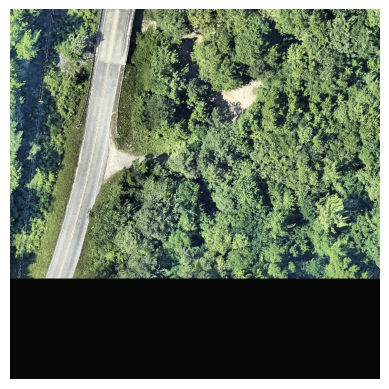

In [36]:
#Test render on a random test image
tree_img = cv2.imread("./Some-Trees-Dataset-11/test/2019_LENO_5_383000_3523000_image_crop_tile_001_000_png.rf.fce852f586adec1c54550aefcb6a17d2.jpg")
plt.imshow(cv2.cvtColor(tree_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

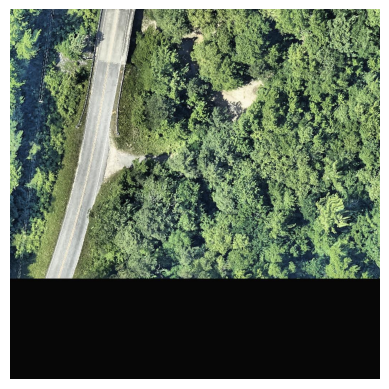

In [42]:
tree_output = predictor(tree_img)
tree_v = Visualizer(tree_img[:, : ,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
tree_vis = tree_v.draw_instance_predictions(tree_output["instances"].to("cpu"))

tree_out = tree_vis.get_image()

plt.imshow(tree_out)
plt.axis('off')
plt.show()

In [39]:
#Loading and registering datasets
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train", {}, './Some-Trees-Dataset-11/train/_annotations.coco.json','./Some-Trees-Dataset-11/train')
register_coco_instances("dataset_valid", {}, './Some-Trees-Dataset-11/valid/_annotations.coco.json', './Some-Trees-Dataset-11/valid')

In [44]:
train_metadata =  MetadataCatalog.get("dataset_train")
train_dicts =  DatasetCatalog.get("dataset_train")

WARNING [09/27 03:55:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/27 03:55:52 d2.data.datasets.coco]: Loaded 1299 images in COCO format from ./Some-Trees-Dataset-11/train/_annotations.coco.json


In [45]:
val_metadata =  MetadataCatalog.get("dataset_valid")
val_dicts =  DatasetCatalog.get("dataset_valid")

WARNING [09/27 03:57:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/27 03:57:03 d2.data.datasets.coco]: Loaded 56 images in COCO format from ./Some-Trees-Dataset-11/valid/_annotations.coco.json


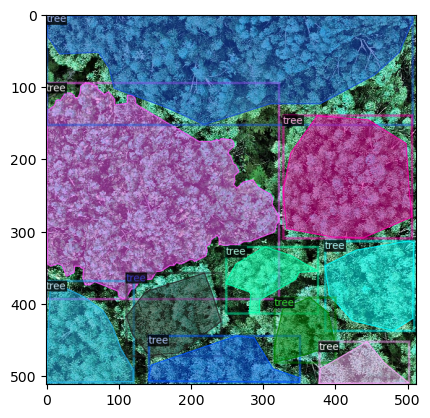

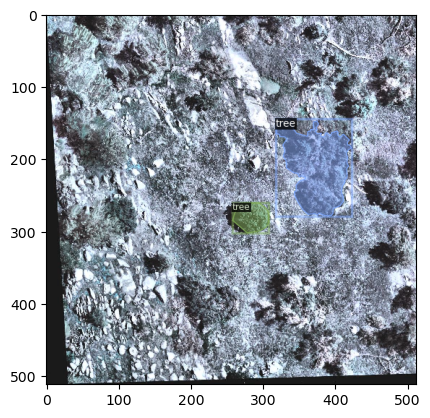

In [50]:
tools.set_seed(42)

for d in random.sample(train_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

## Start Training

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "./mask_rcnn"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS_TRAIN = ("dataset_train")